In [11]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from utils import get_figure, time_plot, moving_average_smoothing, stationarity_tests
from data import get_victoria_electricity_demand, get_oil_weekly_prices

## Time series 1

Time Range: 2017-09-01 00:00:00 - 2013-01-04 00:00:00
Total Time Range: 1701 days 00:00:00
Standard deviation in the interval: 0 days 00:00:00
Mean interval: 7 days 00:00:00
Mode interval: 7 days 00:00:00


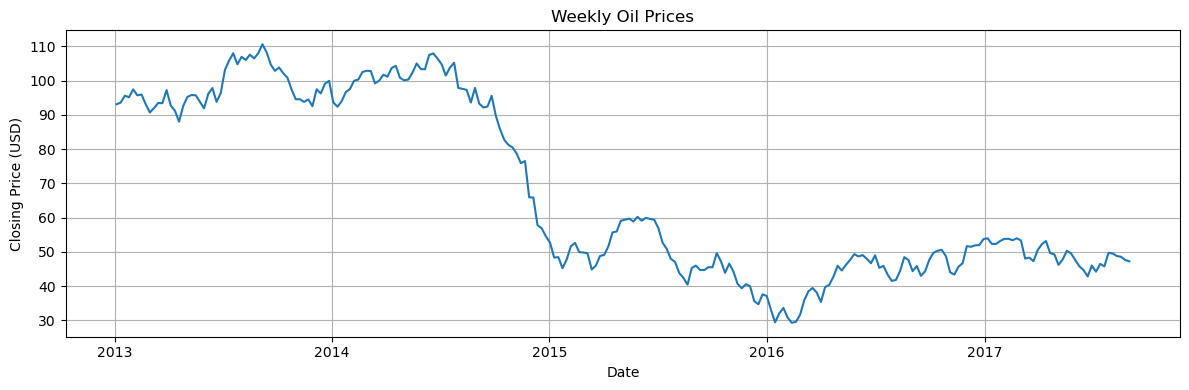

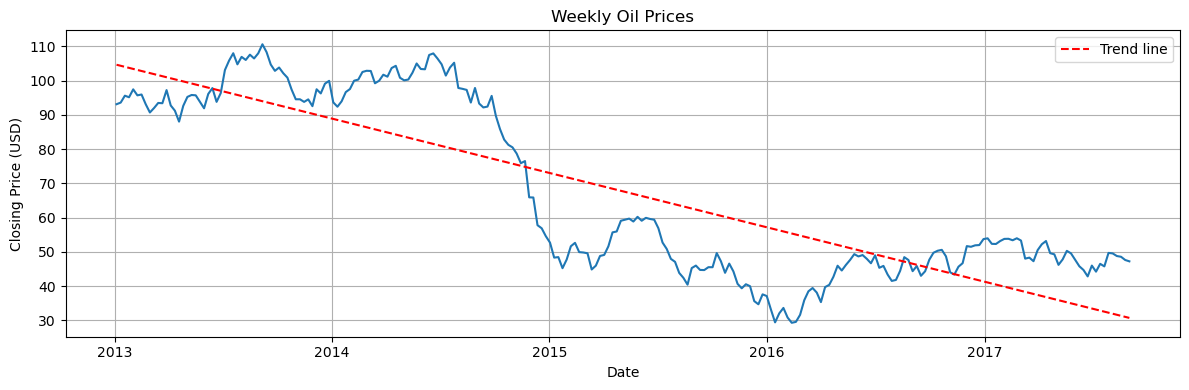

In [2]:
data = get_oil_weekly_prices()

# inspecting time range 
print(f"Time Range: {data.index.max()} - {data.index.min()}" ) 

time_range = data.index.max() - data.index.min()
print("Total Time Range:", time_range)

# Examining the Time Interval
intervals = data.index.to_series().diff().dropna()

print("Standard deviation in the interval:", intervals.std())
print("Mean interval:", intervals.mean())
print("Mode interval:", intervals.mode()[0])

time_plot(
    x=data.index,
    y=data['closing'],
    title='Weekly Oil Prices',
    xlabel='Date',
    ylabel='Closing Price (USD)',
)

time_plot(
    x=data.index,
    y=data['closing'],
    title='Weekly Oil Prices',
    xlabel='Date',
    ylabel='Closing Price (USD)',
    show_trend=True
)

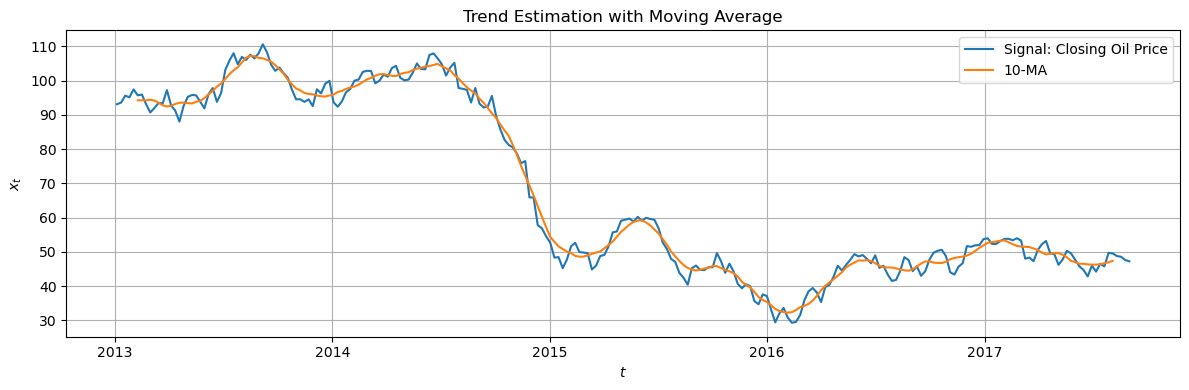

In [91]:
#  patterns we expect to find?
# >> decreasing trend
# >> seasonality with yearly frequency, i.e. Time perid = 12 months 
signal = np.array(data['closing'])
time = np.array(data.index)

# plotting
fig, [ax1] = get_figure(1, 1)
time_plot(
    x=time,
    y=signal, 
    label="Signal: Closing Oil Price",
    ax=ax1
)
_,ma_samples, ma = moving_average_smoothing(signal, 10)
time_plot(
    x=time[ma_samples],
    y=ma, 
    label="10-MA",
    ax=ax1
)
ax1.set_title("Trend Estimation with Moving Average")
fig.tight_layout()
## we need to find the seasonality component

### Classical decomposition

Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       ...
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
      dtype='int32', name='date', length=244)

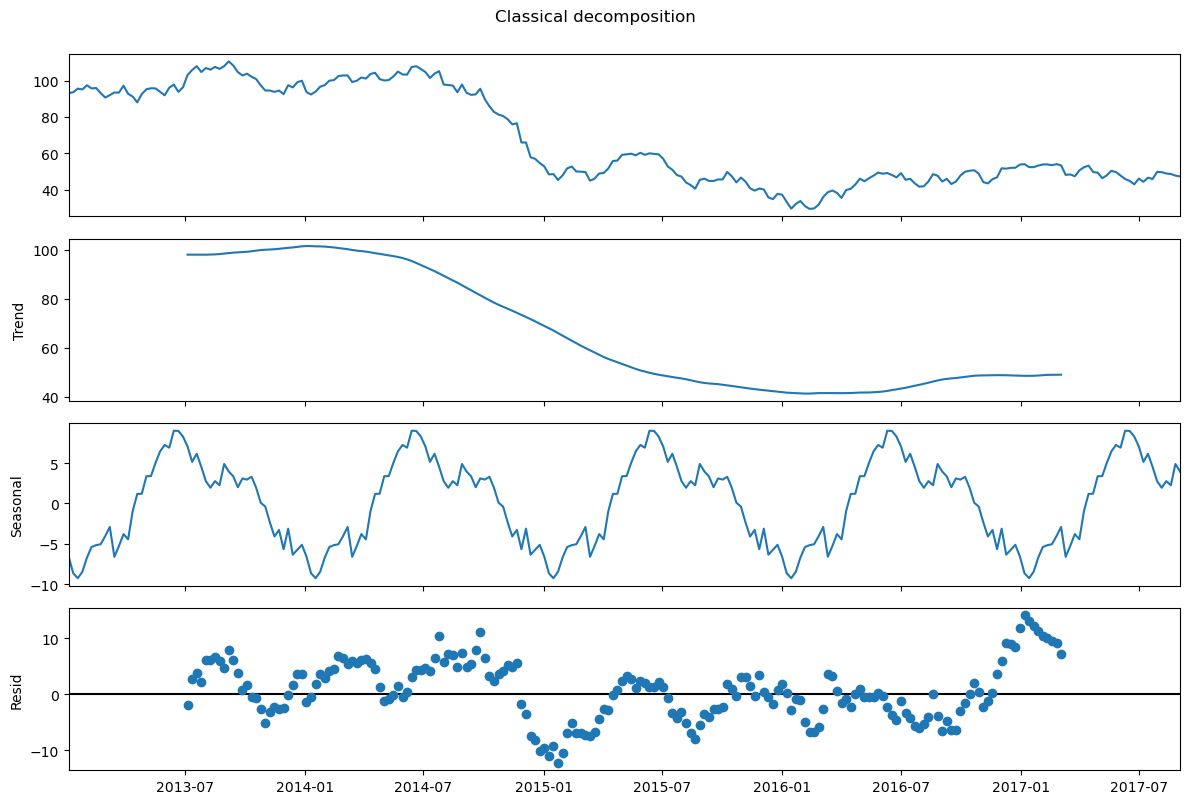

In [5]:
res = seasonal_decompose(data)
fig = res.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Classical decomposition", y=1)
fig.tight_layout()
data.index.year

### Re-implementation

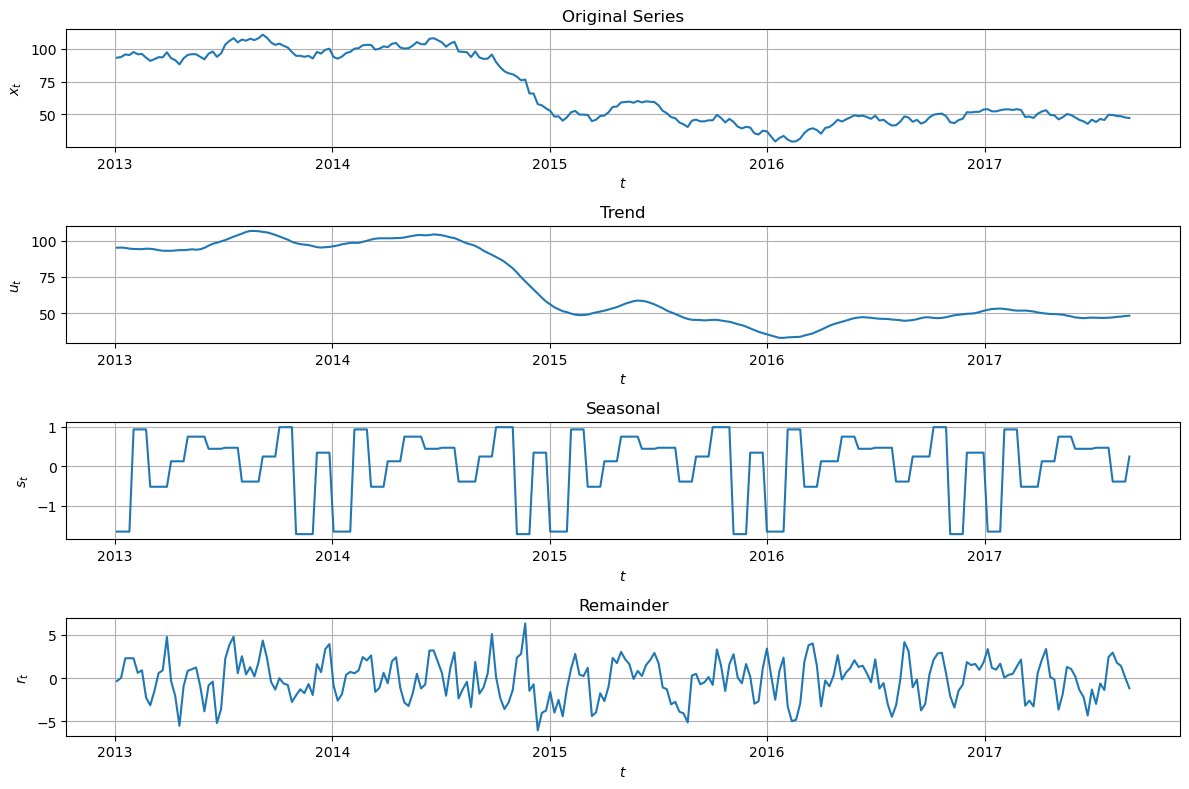

In [8]:
# Detrend series
data['Trend'] = data['closing'].rolling(window=12, center=True, min_periods=1).mean()
data['Detrended'] = data['closing'] - data['Trend']
# Calculate the seasonal components using period adjusted averages
data['Month'] = data.index.month
seasonal_avg = data.groupby('Month')['Detrended'].mean()
# Adjust seasonal components
seasonal_avg_adjusted = seasonal_avg - seasonal_avg.mean()
# Repeat the seasonal component values for each period
data['Seasonal'] = data['Month'].map(seasonal_avg_adjusted)
# Deseasonalize detrended series
data['Remainder'] = data['Detrended'] - data['Seasonal']

fig, [ax1, ax2, ax3, ax4] = get_figure(4, 1, figsize=(12, 8))
time_plot(
    x=data.index,
    y=data['closing'], 
    title='Original Series',
    ax=ax1
)
time_plot(
    x=data.index,
    y=data['Trend'], 
    title='Trend',
    ax=ax2,
    ylabel='$u_t$',
)
time_plot(
    x=data.index,
    y=data['Seasonal'], 
    title='Seasonal',
    ax=ax3,
    ylabel='$s_t$',
)
time_plot(
    x=data.index,
    y=data['Remainder'], 
    title='Remainder',
    ax=ax4,
    ylabel='$r_t$',
)
fig.tight_layout()

### checking stationarity of the remainder 

In [19]:
r_t = np.array(data['Remainder'])
stationarity_tests(r_t)

Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.9290)
	- ZA: Stationary (p-value: 0.0000)


### factors/laws that influenced the data?
### ....